## Data preparation

In [17]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [18]:
df = pd.read_csv('dataset.csv')
print(df.shape)
df.head()

(60030, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Air_India,AI-768,Kolkata,Afternoon,one,Evening,Hyderabad,Economy,26.08,17,10229
1,2,AirAsia,I5-423,Mumbai,Afternoon,two_or_more,Late_Night,Kolkata,Economy,10.67,16,2836
2,3,Air_India,AI-539,Chennai,Evening,one,Afternoon,Bangalore,Business,19.50,49,60260
3,4,Indigo,6E-893,Kolkata,Morning,one,Evening,Bangalore,Economy,8.83,45,3860
4,5,Air_India,AI-526,Kolkata,Evening,one,Early_Morning,Chennai,Economy,13.00,28,3644


In [19]:
df.describe().round()

,Unnamed: 0,duration,days_left,price
count,60030.0,60030.0,60030.0,60030.0
mean,30016.0,12.0,26.0,20989.0
std,17329.0,7.0,14.0,22792.0
min,1.0,1.0,1.0,1105.0
25%,15008.0,7.0,15.0,4779.0
50%,30016.0,11.0,26.0,7425.0
75%,45023.0,16.0,38.0,42521.0
max,60030.0,48.0,49.0,117307.0


In [20]:
df.dtypes

Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [21]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['airline',
 'flight',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class']

In [22]:
for col in categorical:
  df[col] = df[col].str.lower().str.replace(' ', '_')

df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,air_india,ai-768,kolkata,afternoon,one,evening,hyderabad,economy,26.08,17,10229
1,2,airasia,i5-423,mumbai,afternoon,two_or_more,late_night,kolkata,economy,10.67,16,2836
2,3,air_india,ai-539,chennai,evening,one,afternoon,bangalore,business,19.50,49,60260
3,4,indigo,6e-893,kolkata,morning,one,evening,bangalore,economy,8.83,45,3860
4,5,air_india,ai-526,kolkata,evening,one,early_morning,chennai,economy,13.00,28,3644


In [23]:
categorical = [
	'airline',
	'flight',
	'source_city',
	'departure_time',
	'stops',
	'arrival_time',
	'destination_city',
	'class'
]

numerical = [
	'duration',
	'days_left'
]

## EDA

- Features analysis

In [24]:
for col in df.columns:
  print(col)
  print(df[col].unique()[:5])
  print(df[col].nunique())
  print('\n')

Unnamed: 0
[1 2 3 4 5]
60030


airline
['air_india' 'airasia' 'indigo' 'vistara' 'go_first']
6


flight
['ai-768' 'i5-423' 'ai-539' '6e-893' 'ai-526']
1457


source_city
['kolkata' 'mumbai' 'chennai' 'delhi' 'hyderabad']
6


departure_time
['afternoon' 'evening' 'morning' 'night' 'early_morning']
6


stops
['one' 'two_or_more' 'zero']
3


arrival_time
['evening' 'late_night' 'afternoon' 'early_morning' 'night']
6


destination_city
['hyderabad' 'kolkata' 'bangalore' 'chennai' 'mumbai']
6


class
['economy' 'business']
2


duration
[26.08 10.67 19.5   8.83 13.  ]
433


days_left
[17 16 49 45 28]
49


price
[10229  2836 60260  3860  3644]
7128




- Distribution of price

<Axes: xlabel='price', ylabel='Count'>

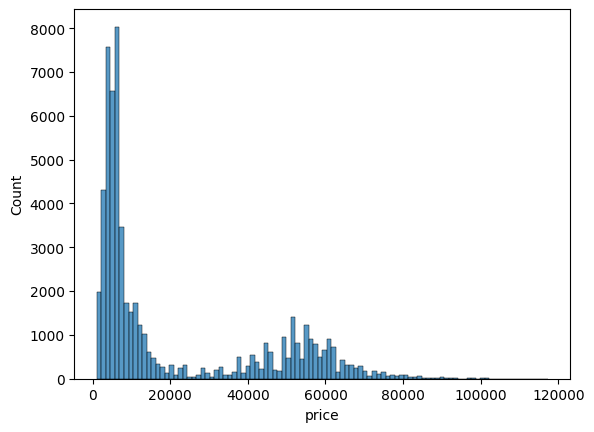

In [25]:
sns.histplot(df.price, bins=100)

<Axes: xlabel='price', ylabel='Count'>

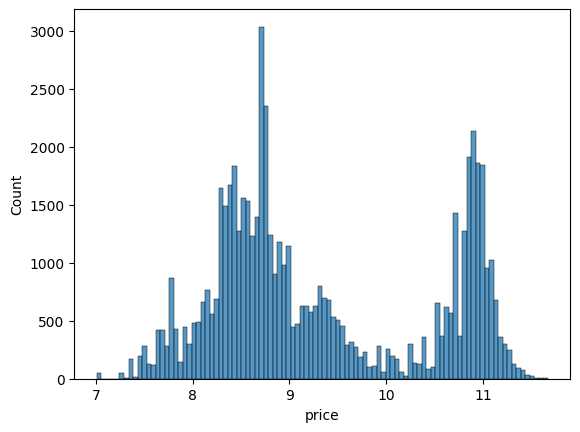

In [26]:
sns.histplot(np.log1p(df.price), bins=100)

- Missing values

In [27]:
df.isna().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

##  Feature Importance

In [32]:
df[numerical].corrwith(df.price)

duration     0.209195
days_left   -0.088979
dtype: float64

In [33]:
from sklearn.metrics import mutual_info_score

In [34]:
scores = []

for f in categorical:
  scores.append(mutual_info_score(df.price, df[f]))

mi_scores = pd.Series(scores, name="MI Scores", index=categorical)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

flight              4.715397
source_city         1.660866
destination_city    1.566511
airline             1.203045
class               0.621259
arrival_time        0.616143
departure_time      0.539035
stops               0.431937
Name: MI Scores, dtype: float64

## Split the dataset

In [35]:
from sklearn.model_selection import train_test_split

df['price'] = np.log1p(df['price'])

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [36]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [37]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [38]:
del df_train['price']
del df_val['price']
del df_test['price']

In [39]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.feature_extraction import DictVectorizer

In [40]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [41]:
full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')

In [42]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [43]:
X_full_train = dv.transform(full_train_dict)
y_full_train = df_full_train.price.values

In [44]:
test_dict = df_test[categorical + numerical].to_dict(orient='records')

In [45]:
X_test = dv.transform(test_dict)

In [23]:
split = ShuffleSplit(test_size=0.25, n_splits=1, random_state=11)

## Riedge Regression

In [46]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [47]:
model = Ridge(alpha=1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# param squared=False to get RMSE
score = mean_squared_error(y_val, y_pred, squared=False)
round(score, 3)

0.291

### Model tuning

- Alpha

In [20]:
from tqdm.auto import tqdm

In [21]:
alphas = [0, 0.01, 0.1, 1, 10]

for a in tqdm(alphas):
  model = Ridge(alpha=a, random_state=42)
  model.fit(X_train, y_train)
  
  y_pred = model.predict(X_val)
  
  score = np.sqrt(mean_squared_error(y_val, y_pred))
  
  print(a, round(score, 3))

  0%|          | 0/5 [00:00<?, ?it/s]

0 443561781121.175
0.01 0.292
0.1 0.292
1 0.291
10 0.294


### Training the optimal model

In [48]:
model = Ridge(alpha=1, random_state=42)

In [49]:
model.fit(X_train, y_train)

Ridge(alpha=1, random_state=42)

In [50]:
y_pred = model.predict(X_val)
score = mean_squared_error(y_val, y_pred, squared=False)
round(score, 3)

0.291

In [58]:
models_scores = {
  'linear_regresion': score
}

## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [56]:

dt = DecisionTreeRegressor(max_depth=30, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=30, random_state=42)

In [62]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- class=economy <= 0.50
|   |--- duration <= 4.46
|   |   |--- duration <= 2.04
|   |   |   |--- duration <= 1.71
|   |   |   |   |--- duration <= 1.29
|   |   |   |   |   |--- destination_city=mumbai <= 0.50
|   |   |   |   |   |   |--- days_left <= 7.00
|   |   |   |   |   |   |   |--- value: [9.65]
|   |   |   |   |   |   |--- days_left >  7.00
|   |   |   |   |   |   |   |--- days_left <= 17.50
|   |   |   |   |   |   |   |   |--- value: [9.40]
|   |   |   |   |   |   |   |--- days_left >  17.50
|   |   |   |   |   |   |   |   |--- value: [9.40]
|   |   |   |   |   |--- destination_city=mumbai >  0.50
|   |   |   |   |   |   |--- days_left <= 20.00
|   |   |   |   |   |   |   |--- value: [9.78]
|   |   |   |   |   |   |--- days_left >  20.00
|   |   |   |   |   |   |   |--- value: [9.78]
|   |   |   |   |--- duration >  1.29
|   |   |   |   |   |--- arrival_time=morning <= 0.50
|   |   |   |   |   |   |--- flight=ai-507 <= 0.50
|   |   |   |   |   |   |   |--- days_left <= 5.50


In [59]:
y_pred = dt.predict(X_val)

In [60]:
score = mean_squared_error(y_val, y_pred, squared=False)
round(score, 3)

0.198

### Model Tuning

- Max Depths

In [21]:
depths = list(range(35, 50))
depths.append(None)
depths

[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, None]

In [89]:
grid = {
  'max_depth': depths,
  'random_state': [42]
}

gs = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid, cv=split, verbose=2, scoring='neg_root_mean_squared_error')

In [90]:
gs.fit(X_full_train, y_full_train)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] END ......................max_depth=35, random_state=42; total time=   8.9s
[CV] END ......................max_depth=36, random_state=42; total time=   8.8s
[CV] END ......................max_depth=37, random_state=42; total time=   8.7s
[CV] END ......................max_depth=38, random_state=42; total time=   8.9s
[CV] END ......................max_depth=39, random_state=42; total time=   7.7s
[CV] END ......................max_depth=40, random_state=42; total time=   7.7s
[CV] END ......................max_depth=41, random_state=42; total time=   8.2s
[CV] END ......................max_depth=42, random_state=42; total time=   7.6s
[CV] END ......................max_depth=43, random_state=42; total time=   7.7s
[CV] END ......................max_depth=44, random_state=42; total time=   7.4s
[CV] END ......................max_depth=45, random_state=42; total time=   7.9s
[CV] END ......................max_depth=46, ran

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=11, test_size=0.25, train_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
                                       45, 46, 47, 48, 49, None],
                         'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [92]:
gs_scores = pd.DataFrame.from_dict(gs.cv_results_)
gs_scores = gs_scores[['rank_test_score', 'param_max_depth', 'mean_test_score']].sort_values('rank_test_score')
gs_scores[['mean_test_score']] = gs_scores[['mean_test_score']].map(lambda x: '%.3f' % x)
gs_scores

,rank_test_score,param_max_depth,mean_test_score
9,1,44,-0.197
13,2,48,-0.198
5,3,40,-0.198
12,4,47,-0.198
10,5,45,-0.198
3,6,38,-0.198
6,7,41,-0.198
4,8,39,-0.198
1,9,36,-0.199
7,10,42,-0.199


- Min Sample

In [110]:
s = [1, 5, 10, 15, 20, 500, 100, 200]

In [111]:
grid = {
  'max_depth': [43, 44, 45],
  'min_samples_leaf': s,
  'random_state': [42]
}

gs = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid, cv=split, verbose=2, scoring='neg_root_mean_squared_error')

In [112]:
gs.fit(X_full_train, y_full_train)

Fitting 1 folds for each of 24 candidates, totalling 24 fits
[CV] END ..max_depth=43, min_samples_leaf=1, random_state=42; total time=   8.0s
[CV] END ..max_depth=43, min_samples_leaf=5, random_state=42; total time=   8.3s
[CV] END .max_depth=43, min_samples_leaf=10, random_state=42; total time=   7.9s
[CV] END .max_depth=43, min_samples_leaf=15, random_state=42; total time=   7.6s
[CV] END .max_depth=43, min_samples_leaf=20, random_state=42; total time=   7.6s
[CV] END max_depth=43, min_samples_leaf=500, random_state=42; total time=   7.0s
[CV] END max_depth=43, min_samples_leaf=100, random_state=42; total time=   7.3s
[CV] END max_depth=43, min_samples_leaf=200, random_state=42; total time=   7.3s
[CV] END ..max_depth=44, min_samples_leaf=1, random_state=42; total time=   8.1s
[CV] END ..max_depth=44, min_samples_leaf=5, random_state=42; total time=   7.7s
[CV] END .max_depth=44, min_samples_leaf=10, random_state=42; total time=   7.9s
[CV] END .max_depth=44, min_samples_leaf=15, ran

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=11, test_size=0.25, train_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [43, 44, 45],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200],
                         'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [121]:
gs_scores = pd.DataFrame.from_dict(gs.cv_results_)
gs_scores_pivot = gs_scores.pivot(index='param_min_samples_leaf', columns=['param_max_depth'], values=['mean_test_score'])
gs_scores_pivot.round(3)

mean_test_score              
param_max_depth                     43     44     45
param_min_samples_leaf                              
1                               -0.200 -0.197 -0.198
5                               -0.194 -0.194 -0.194
10                              -0.196 -0.196 -0.196
15                              -0.200 -0.200 -0.200
20                              -0.204 -0.204 -0.204
100                             -0.225 -0.225 -0.225
200                             -0.236 -0.236 -0.236
500                             -0.251 -0.251 -0.251

<Axes: xlabel='None-param_max_depth', ylabel='param_min_samples_leaf'>

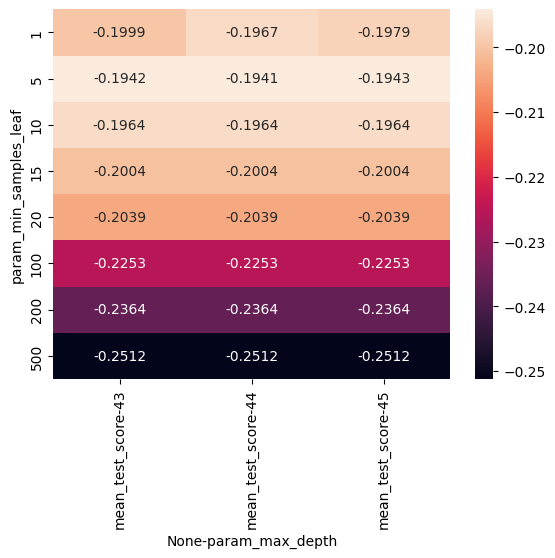

In [125]:
sns.heatmap(gs_scores_pivot, annot=True, fmt=".4f")

### Training the optimal model

In [61]:
dt = DecisionTreeRegressor(random_state=42, max_depth=44, min_samples_leaf=5)

In [65]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=44, min_samples_leaf=5, random_state=42)

In [66]:
y_pred = dt.predict(X_val)

In [67]:
score = mean_squared_error(y_val, y_pred, squared=False)
round(score, 3)

0.194

In [68]:
models_scores['desicion_tree'] = score

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor

### Model tuning

- Nº estimators

In [39]:
n_estimators = list(range(10, 201, 10))
n_estimators

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200]

In [49]:
grid = {
  'n_estimators': n_estimators,
  'random_state': [42],
  'n_jobs': [-1]
}

gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=split, verbose=2, scoring='neg_root_mean_squared_error')

In [50]:
gs.fit(X_full_train, y_full_train)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] END ........n_estimators=10, n_jobs=-1, random_state=42; total time=  53.0s
[CV] END ........n_estimators=20, n_jobs=-1, random_state=42; total time= 1.2min
[CV] END ........n_estimators=30, n_jobs=-1, random_state=42; total time= 2.6min
[CV] END ........n_estimators=40, n_jobs=-1, random_state=42; total time= 3.5min
[CV] END ........n_estimators=50, n_jobs=-1, random_state=42; total time= 5.0min
[CV] END ........n_estimators=60, n_jobs=-1, random_state=42; total time= 5.4min
[CV] END ........n_estimators=70, n_jobs=-1, random_state=42; total time= 5.2min
[CV] END ........n_estimators=80, n_jobs=-1, random_state=42; total time= 4.7min
[CV] END ........n_estimators=90, n_jobs=-1, random_state=42; total time= 5.3min
[CV] END .......n_estimators=100, n_jobs=-1, random_state=42; total time= 5.8min
[CV] END .......n_estimators=110, n_jobs=-1, random_state=42; total time= 6.5min
[CV] END .......n_estimators=120, n_jobs=-1, ran

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=11, test_size=0.25, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200],
                         'n_jobs': [-1], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [56]:
gs_scores = pd.DataFrame.from_dict(gs.cv_results_)
gs_scores = gs_scores[['rank_test_score', 'param_n_estimators', 'mean_test_score']].sort_values('rank_test_score')
gs_scores.round(3)

,rank_test_score,param_n_estimators,mean_test_score
19,1,200,-0.153
18,2,190,-0.153
15,3,160,-0.154
17,4,180,-0.154
16,5,170,-0.154
14,6,150,-0.154
13,7,140,-0.154
7,8,80,-0.154
12,9,130,-0.154
11,10,120,-0.154


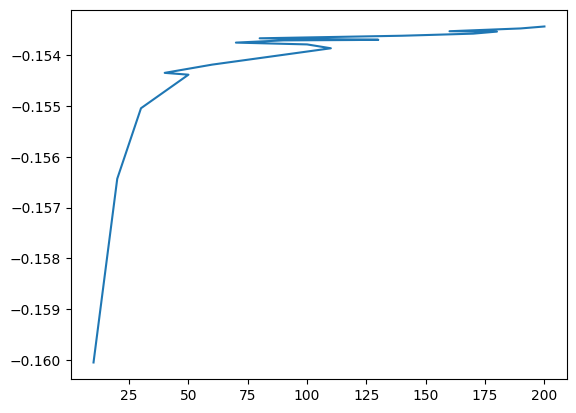

In [57]:
plt.plot(gs_scores.param_n_estimators, gs_scores.mean_test_score)

- Max depths

In [28]:
est = [10, 40, 80, 100, 150, 200]

In [29]:
max_depth = [5] + (list(range(10, 101, 10)))
max_depth

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [30]:
grid = {
  'max_depth': max_depth,
  'n_estimators': est,
  'random_state': [42],
  'n_jobs': [-1]
}

gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=split, verbose=2, scoring='neg_root_mean_squared_error')

In [31]:
gs.fit(X_full_train, y_full_train)

Fitting 1 folds for each of 66 candidates, totalling 66 fits


[CV] END max_depth=5, n_estimators=10, n_jobs=-1, random_state=42; total time=  22.2s
[CV] END max_depth=5, n_estimators=40, n_jobs=-1, random_state=42; total time= 1.3min
[CV] END max_depth=5, n_estimators=80, n_jobs=-1, random_state=42; total time= 2.4min
[CV] END max_depth=5, n_estimators=100, n_jobs=-1, random_state=42; total time= 3.1min
[CV] END max_depth=5, n_estimators=150, n_jobs=-1, random_state=42; total time= 4.6min
[CV] END max_depth=5, n_estimators=200, n_jobs=-1, random_state=42; total time= 6.1min
[CV] END max_depth=10, n_estimators=10, n_jobs=-1, random_state=42; total time=  23.7s
[CV] END max_depth=10, n_estimators=40, n_jobs=-1, random_state=42; total time= 1.5min
[CV] END max_depth=10, n_estimators=80, n_jobs=-1, random_state=42; total time= 3.0min
[CV] END max_depth=10, n_estimators=100, n_jobs=-1, random_state=42; total time= 3.7min
[CV] END max_depth=10, n_estimators=150, n_jobs=-1, random_state=42; total time= 5.5min
[CV] END max_depth=10, n_estimators=200, n_j

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=11, test_size=0.25, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100],
                         'n_estimators': [10, 40, 80, 100, 150, 200],
                         'n_jobs': [-1], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [56]:
gs_scores = pd.DataFrame.from_dict(gs.cv_results_)
gs_scores = gs_scores[['rank_test_score', 'param_n_estimators', 'param_max_depth', 'mean_test_score']].sort_values('rank_test_score')
gs_scores.round(3)[:10]

,rank_test_score,param_n_estimators,param_max_depth,mean_test_score
59,1,200,90,-0.153
65,2,200,100,-0.153
47,3,200,70,-0.153
41,4,200,60,-0.153
53,5,200,80,-0.154
64,6,150,100,-0.154
58,7,150,90,-0.154
62,8,80,100,-0.154
52,9,150,80,-0.154
46,10,150,70,-0.154


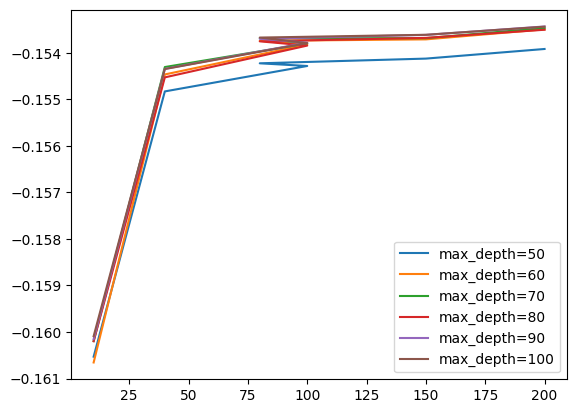

In [57]:
for d in (list(range(50, 101, 10))):
    df_subset = gs_scores[gs_scores.param_max_depth == d]
    
    plt.plot(df_subset.param_n_estimators, df_subset.mean_test_score,
             label='max_depth=%d' % d)

plt.legend()

In [26]:
max_depth = [60]


- Min samples leaf

In [27]:
s = [1, 3, 5, 7, 10, 20]

In [28]:
est = [10, 40, 80, 100, 150, 200]

In [29]:
grid = {
  'max_depth': max_depth,
  'n_estimators': est,
  'min_samples_leaf': s,
  'random_state': [42],
  'n_jobs': [-1]
}

gs_s = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv=split, verbose=2, scoring='neg_root_mean_squared_error')

In [30]:
gs_s.fit(X_full_train, y_full_train)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END max_depth=60, min_samples_leaf=1, n_estimators=10, n_jobs=-1, random_state=42; total time=  27.5s
[CV] END max_depth=60, min_samples_leaf=1, n_estimators=40, n_jobs=-1, random_state=42; total time= 1.6min
[CV] END max_depth=60, min_samples_leaf=1, n_estimators=80, n_jobs=-1, random_state=42; total time= 3.3min
[CV] END max_depth=60, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42; total time= 4.2min
[CV] END max_depth=60, min_samples_leaf=1, n_estimators=150, n_jobs=-1, random_state=42; total time= 6.3min
[CV] END max_depth=60, min_samples_leaf=1, n_estimators=200, n_jobs=-1, random_state=42; total time= 8.3min
[CV] END max_depth=60, min_samples_leaf=3, n_estimators=10, n_jobs=-1, random_state=42; total time=  25.1s
[CV] END max_depth=60, min_samples_leaf=3, n_estimators=40, n_jobs=-1, random_state=42; total time= 1.6min
[CV] END max_depth=60, min_samples_leaf=3, n_estimators=80, n_jobs=-1, random_st

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=11, test_size=0.25, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [60],
                         'min_samples_leaf': [1, 3, 5, 7, 10, 20],
                         'n_estimators': [10, 40, 80, 100, 150, 200],
                         'n_jobs': [-1], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [31]:
gs_scores_s = pd.DataFrame.from_dict(gs_s.cv_results_)
gs_scores_s = gs_scores_s[['rank_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score']].sort_values('rank_test_score')
gs_scores_s.round(4)[:10]

,rank_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,mean_test_score
5,1,200,60,1,-0.1535
4,2,150,60,1,-0.1537
2,3,80,60,1,-0.1537
3,4,100,60,1,-0.1538
1,5,40,60,1,-0.1545
0,6,10,60,1,-0.1607
11,7,200,60,3,-0.1637
10,8,150,60,3,-0.1639
9,9,100,60,3,-0.1640
8,10,80,60,3,-0.1642


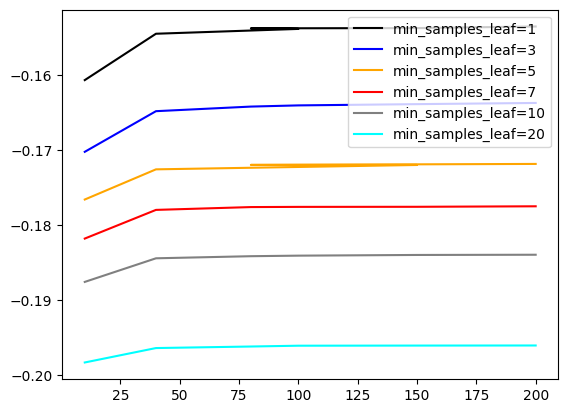

In [32]:
colors = ['black', 'blue', 'orange', 'red', 'grey', 'cyan']

for s, col in zip(s, colors):
    df_subset = gs_scores_s[gs_scores_s.param_min_samples_leaf == s]
    
    plt.plot(df_subset.param_n_estimators, df_subset.mean_test_score,
                color=col,
                label='min_samples_leaf=%d' % s)

plt.legend()

### Train the optimal model

In [73]:
rf_model = RandomForestRegressor(random_state=42,
                                n_jobs=-1,
                                n_estimators=80,
                                max_depth=60,
                                min_samples_leaf=1)

In [74]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, n_estimators=80, n_jobs=-1, random_state=42)

In [75]:
y_pred = rf_model.predict(X=X_val)

In [77]:
score = mean_squared_error(y_val, y_pred, squared=False)
round(score, 3)

0.154

In [78]:
models_scores['random_forest'] = score

## Select best model

### Order models

In [83]:
sorted(models_scores.items(), key=lambda x: x[1])

[('random_forest', 0.15374297724874447),
 ('desicion_tree', 0.19411706732894693),
 ('linear_regresion', 0.29767239656653677)]

### Full train

In [84]:
rf = RandomForestRegressor(random_state=42,
                          n_jobs=-1,
                          n_estimators=80,
                          min_samples_leaf=1,
                          max_depth=60)

In [86]:
rf.fit(X_full_train, y_full_train)

RandomForestRegressor(max_depth=60, n_estimators=80, n_jobs=-1, random_state=42)

In [87]:
y_pred = rf.predict(X_test)

In [88]:
score =  mean_squared_error(y_test, y_pred, squared=False)
round(score, 3)

0.155